In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import work.classifier as wc

from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target
print(X.shape)
print(y.shape)

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:91: UserWarning: A network error occurred while downloading https://openml.org/api/v1/json/data/features/554. Retrying...
  warn(


(70000, 784)
(70000,)


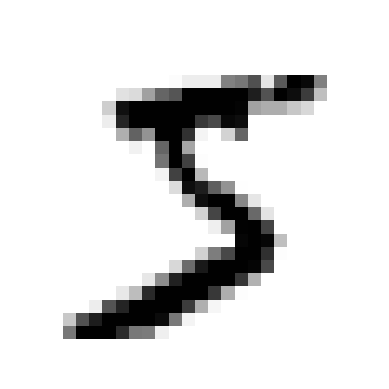

In [3]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

some_digit=X[0]
plot_digit(some_digit)

In [4]:
y[0]

'5'

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
np.save("002_minst-X_train.npy", X_train)
np.save("002_minst-y_train.npy", y_train)

## Binary classifier

In [7]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [8]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

# cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
dummy_y_train_pred = cross_val_predict(dummy_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, dummy_y_train_pred)

array([[54579,     0],
       [ 5421,     0]])

In [9]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [10]:
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311
0.7325171197343846


### precision / recall

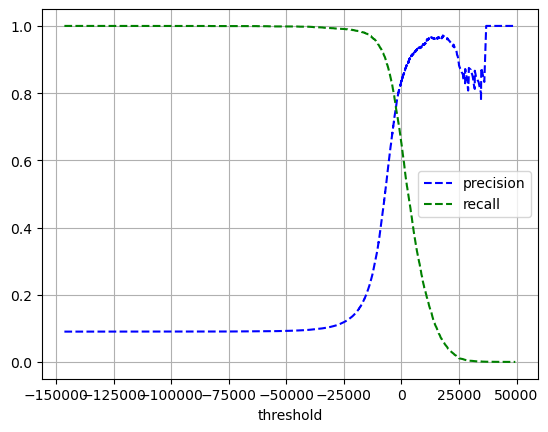

In [11]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="precision")
plt.plot(thresholds, recalls[:-1], "g--", label="recall")
plt.grid()
plt.xlabel("threshold")
plt.legend()
plt.show()

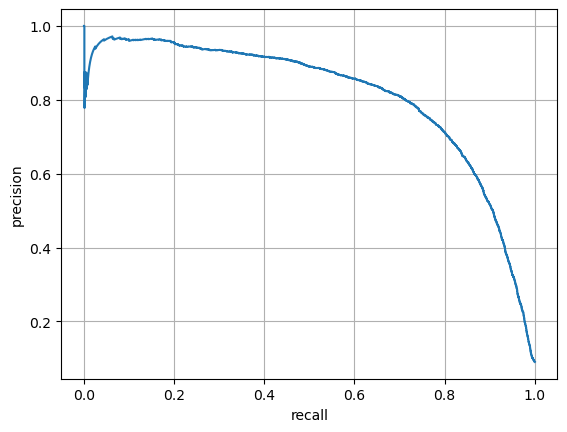

In [12]:
plt.plot(recalls, precisions)
plt.grid()
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

In [13]:
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [14]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### roc

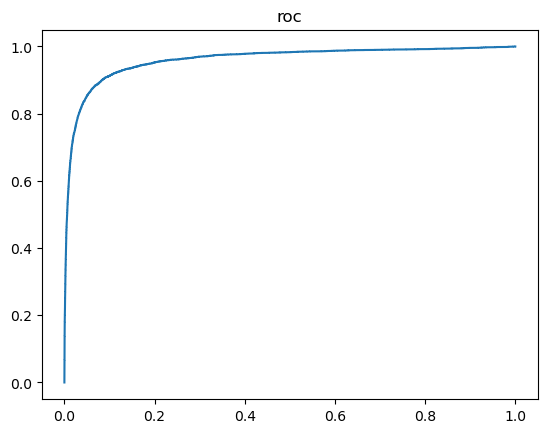

In [15]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plt.plot(fpr, tpr)
plt.title("roc")
plt.show()


In [16]:
roc_auc_score(y_train_5, y_scores)
# random classifier has 0.5

0.9604938554008616

In [17]:
forest_clf = RandomForestClassifier(random_state=42)
y_scores = cross_val_predict(forest_clf, X_train, y_train_5, method="predict_proba", n_jobs=-1)

In [18]:
wc.precisionRecall_check(forest_clf, X_train, y_train_5)

[[54536    43]
 [  686  4735]]

precision: 0.9910004185851821
recall:    0.8734550820881756
f1:        0.9285224041572703


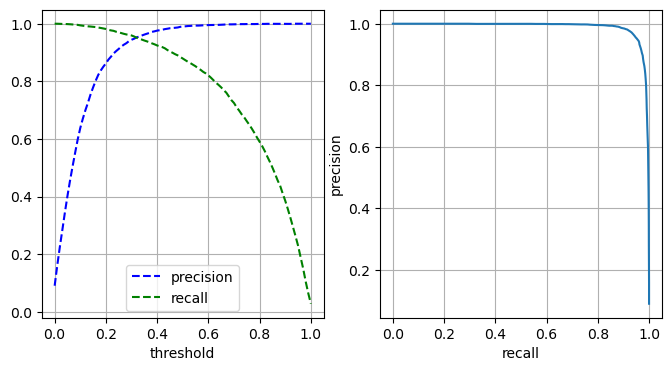

In [19]:
y_s = wc.precisionRecall_curve(forest_clf, X_train, y_train_5, y_scores[:, 1])

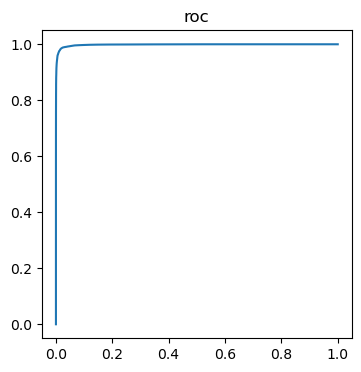

Area under: 0.998402186461512


In [20]:
wc.recallFallout_curve(forest_clf, X_train, y_train_5, y_scores[:, 1])

## Multiclass

In [21]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [22]:
svm_clf.decision_function([some_digit])
# this is implicitly using OvO, hence 45 classifiers has been trained (10*9/2)

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

In [23]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [24]:
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [25]:
len(ovr_clf.estimators_)

10

In [26]:
ovr_clf.decision_function([some_digit])

array([[-1.32802451, -1.79073853, -1.39262214, -0.94416346, -2.29003973,
         0.80921042, -1.72304481, -1.20954271, -1.63739176, -1.79246052]])

### Error

In [27]:
X_train_scaled = StandardScaler().fit_transform(X_train.astype("float64"))
y_train_pred = cross_val_predict(SGDClassifier(random_state=42), X_train_scaled, y_train, cv=3, n_jobs=-1)

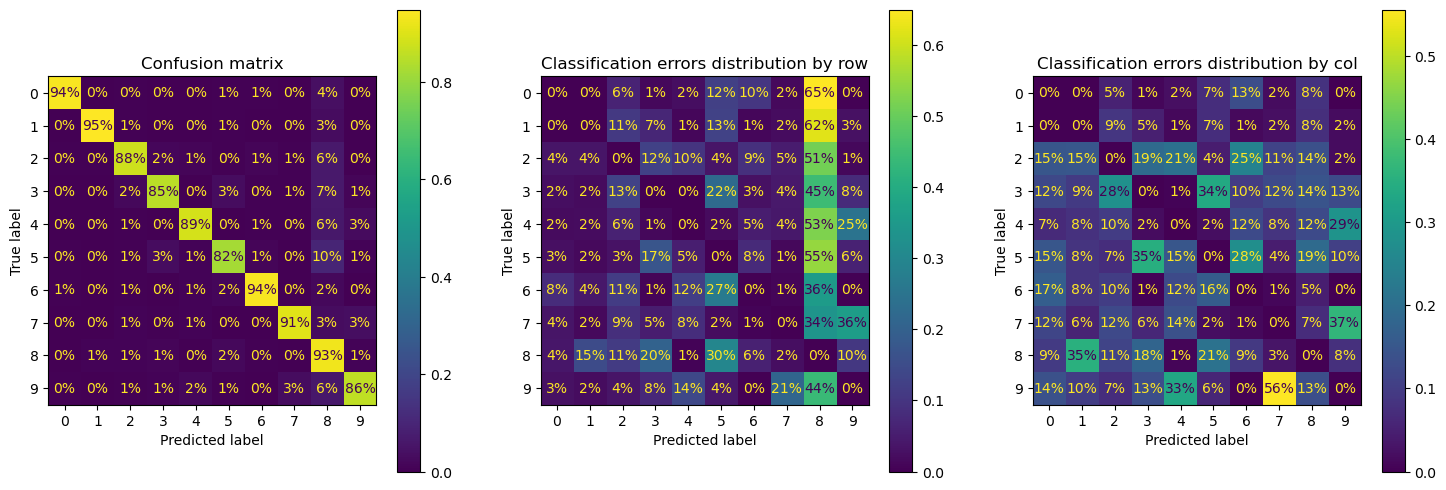

In [30]:
wc.confusionMatrix_from_predictions(y_train, y_train_pred)

### ClassifierChain

when a model makes predition, it uses the input features plus all the predictions of the model that come before it in the chain

In [29]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)